In [3]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
import numpy as np

In [4]:
player_df = pd.read_csv('finalplayerdata.csv', low_memory=False)

In [5]:
#drop the columns that arent needed
final_df = player_df.drop(columns=['full_name', 'version','description', 'image', 'potential', 'wage', 'preferred_foot', 'international_reputation', 'work_rate',
                                    'body_type', 'real_face', 'release_clause', 'specialities', 'club_id', 'club_logo', 'club_rating', 
                                    'club_kit_number', 'club_joined', 'club_contract_valid_until', 'country_id', 'country_league_id', 'country_league_name',
                                    'country_flag', 'country_rating', 'country_position', 'country_kit_number', 'play_styles', 'gk_diving', 'gk_handling', 
                                   'gk_kicking', 'club_position'])

#make the player names lowercase to make it easier to search
final_df['name'] = final_df['name'].str.lower()

#player_df = player_df.drop_duplicates()
final_df.drop_duplicates(subset=['name'])


#remove accented and other special characters from the players names. These were some of the most common ones I saw. 
mapping = {'á': 'a',
           'é': 'e',
           'í': 'i',
           'ó': 'o',
           'ú': 'u',
           'ñ': 'n',
           'ã': 'a',
           'ë': 'e',
           'ş': 's',
           'ă': 'a'}

final_df['name'] = final_df.name.replace(mapping, regex=True)
final_df['club_name'] = final_df.club_name.replace(mapping, regex=True)

In [6]:
#drop the goalkeepers
final_df = final_df[pd.to_numeric(final_df['gk_positioning'], errors='coerce').notnull()]
final_df = final_df[pd.to_numeric(final_df['gk_reflexes'], errors='coerce').notnull()]

In [7]:
#cluster_df is a copy of the dataframe we will do the cluster analysis on. Will add the clusters back to final_df in the end
cluster_df = final_df.copy()
cluster_df

,player_id,name,height_cm,weight_kg,dob,positions,overall_rating,value,weak_foot,skill_moves,...,interceptions,positioning,vision,penalties,composure,defensive_awareness,standing_tackle,sliding_tackle,gk_positioning,gk_reflexes
0,239085,erling haaland,195,94,7/21/00,ST,91,€185M,3,3,...,43,96,74,86,87,38,47,29,11,7.0
1,231747,kylian mbappe,182,75,12/20/98,"ST,LW",91,€181.5M,4,5,...,38,93,83,84,88,26,34,32,11,6.0
2,192985,kevin de bruyne,181,75,6/28/91,"CM,CAM",91,€103M,5,4,...,66,88,95,83,88,66,70,53,10,13.0
3,231866,rodri,191,82,6/22/96,"CDM,CM",90,€122.5M,4,3,...,84,76,84,62,87,92,87,78,14,8.0
4,202126,harry kane,188,85,7/28/93,ST,90,€119.5M,5,3,...,42,94,87,92,92,46,46,38,14,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18326,272761,lyu jiaqiang,180,65,4/11/05,CB,47,€100K,3,2,...,50,28,30,34,37,51,50,53,7,15.0
18327,275601,callum warren,172,67,3/16/05,CAM,47,€110K,3,2,...,30,49,49,40,51,29,38,34,7,10.0
18328,71064,ishaan shishodia,177,70,8/31/05,"CM,CAM",47,€110K,3,2,...,42,48,49,37,44,33,38,42,13,13.0
18329,269541,wu yuhang,182,75,2/16/01,CDM,47,€70K,3,2,...,43,37,35,41,39,40,45,51,13,8.0


In [8]:
#implement the elbow method to find the number of clusters

numerical_features = ['crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve', 'fk_accuracy', 'long_passing', 'ball_control', 'acceleration',
                     'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'aggression', 'interceptions', 'positioning', 
                     'vision', 'penalties', 'composure', 'defensive_awareness', 'standing_tackle', 'sliding_tackle', 'gk_reflexes', 'gk_positioning']

In [9]:
#https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/

In [10]:
warnings.filterwarnings('ignore')
interia_scores = []
for test_k in range(2, 32, 2):
    print(test_k)

    # Select numerical features for clustering
    matrix_reduced = cluster_df[numerical_features].values

    # Fit KMeans model
    tmp_model = KMeans(n_clusters=test_k)
    tmp_model.fit(matrix_reduced)

    # Compute inertia score
    score = tmp_model.inertia_
    interia_scores.append((test_k, score))

2
4
6
8
10
12
14
16
18
20
22
24
26
28
30


In [11]:
intertia_df = pd.DataFrame(interia_scores, columns=["k", "score"])
intertia_df

,k,score
0,2,8.637446e+07
1,4,4.908229e+07
2,6,4.115158e+07
3,8,3.670878e+07
4,10,3.389252e+07
5,12,3.186332e+07
6,14,3.033905e+07
7,16,2.915153e+07
8,18,2.826318e+07
9,20,2.752811e+07


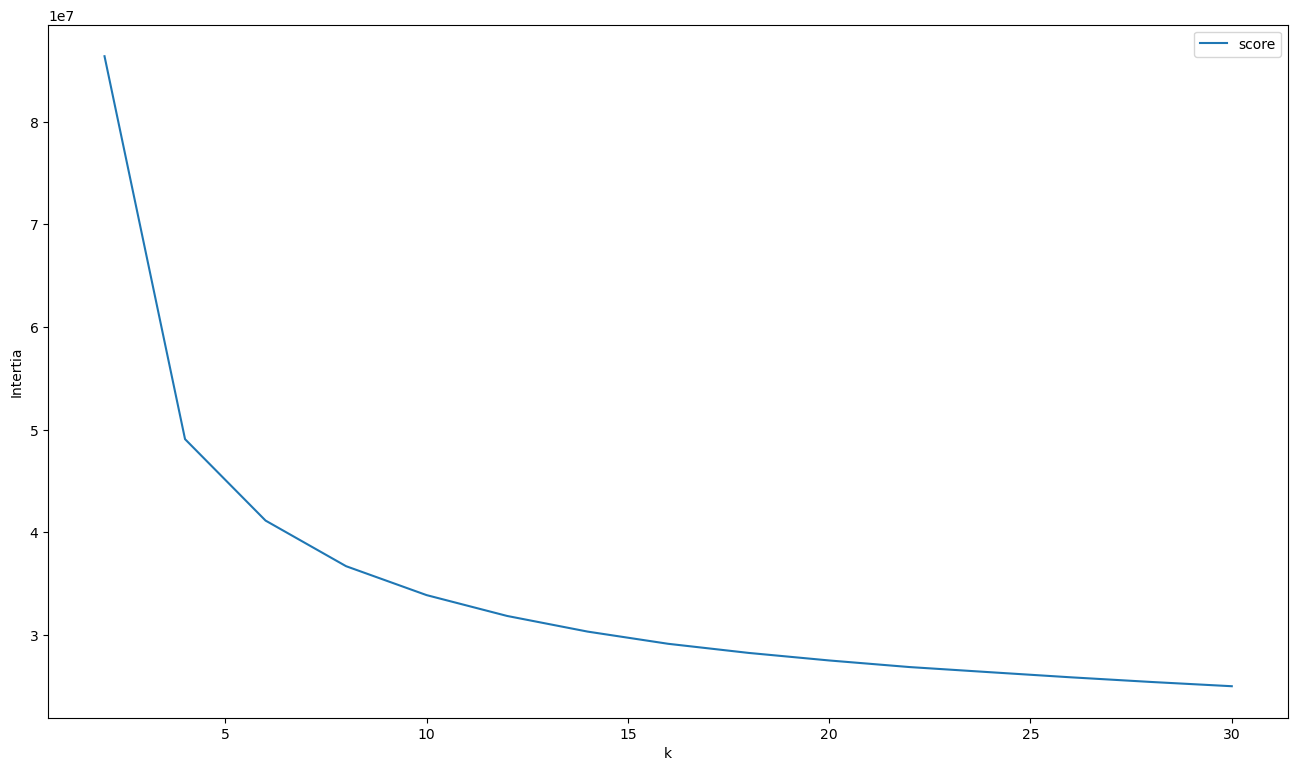

In [12]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1,1,1)
intertia_df.plot("k", "score", ax=ax)
ax.set_ylabel("Intertia")
plt.show()

In [13]:
#we should use a k value of 6

In [14]:
scaler = StandardScaler()
cluster_df[numerical_features] = scaler.fit_transform(cluster_df[numerical_features])
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(cluster_df[numerical_features])
cluster_labels = kmeans.predict(cluster_df[numerical_features])
player_cluster_df = pd.DataFrame(cluster_labels, index=cluster_df[numerical_features].index, columns=["cluster"])

In [15]:
clusters = kmeans.labels_

In [16]:
final_df['cluster'] = kmeans.labels_

In [17]:
clusters_new_df = final_df[['overall_rating', 'finishing', 'shot_power', 'short_passing', 'long_passing', 'stamina', 'strength', 'defensive_awareness', 'gk_positioning', 'gk_reflexes',
                         'agility', 'sprint_speed', 'standing_tackle', 'sliding_tackle', 'cluster']]

In [18]:
cluster_new_avg = clusters_new_df.groupby('cluster').mean().round()

In [19]:
cluster_new_avg

,overall_rating,finishing,shot_power,short_passing,long_passing,stamina,strength,defensive_awareness,gk_reflexes,agility,sprint_speed,standing_tackle,sliding_tackle
cluster,,,,,,,,,,,,,
0,59.0,50.0,54.0,58.0,52.0,59.0,50.0,38.0,10.0,70.0,70.0,42.0,40.0
1,63.0,29.0,44.0,56.0,50.0,64.0,73.0,62.0,10.0,53.0,61.0,64.0,62.0
2,64.0,10.0,47.0,28.0,28.0,28.0,60.0,13.0,66.0,38.0,36.0,14.0,14.0
3,68.0,47.0,59.0,66.0,62.0,72.0,69.0,63.0,10.0,67.0,68.0,66.0,64.0
4,73.0,65.0,72.0,73.0,69.0,75.0,65.0,56.0,10.0,75.0,71.0,59.0,55.0
5,66.0,67.0,68.0,61.0,49.0,65.0,70.0,28.0,10.0,68.0,73.0,27.0,25.0


In [20]:
new_df = pd.DataFrame(final_df[['name', 'overall_rating', 'cluster', 'positions', 'value']])

In [21]:
def top_five_players(group):
    return group.nlargest(5, 'overall_rating')

In [22]:
top_players_by_cluster = new_df.groupby('cluster').apply(top_five_players)

In [23]:
top_players_by_cluster

name  overall_rating  cluster positions  \
cluster                                                                  
0       2229        michael dimeira              74        0    CAM,RM   
        2543     patricio rodriguez              73        0     LW,LM   
        3037          kevin paredes              72        0        LM   
        3090           barrie mckay              72        0     LM,LW   
        3223           mateo puerta              72        0        RB   
1       178             willi orban              83        1        CB   
        215        robin le normand              82        1        CB   
        348            stefan savić              81        1        CB   
        382                  ibanez              80        1        CB   
        562        philipp lienhart              79        1        CB   
2       5          thibaut courtois              90        2        GK   
        10                  alisson              89        2        GK   
        13    marc-andre ter stegen              89        2        GK   
        20                  ederson              88        2        GK   
        21                jan oblak              88        2        GK   
3       8                ruben dias              89        3        CB   
        32               marquinhos              87        3        CB   
        37            ronald araujo              86        3     CB,RB   
        42             eder militao              86        3        CB   
        64             jules kounde              85        3     CB,RB   
4       0            erling haaland              91        4        ST   
        1             kylian mbappe              91        4     ST,LW   
        2           kevin de bruyne              91        4    CM,CAM   
        3                     rodri              90        4    CDM,CM   
        4                harry kane              90        4        ST   
5       198             boulaye dia              82        5  ST,LW,CF   
        211       youssef en-nesyri              82        5        ST   
        270                  joselu              82        5        ST   
        284         viktor gyökeres              81        5        ST   
        307             oswaldinato              81        5        ST   

                value  
cluster                
0       2229    €3.5M  
        2543    €1.9M  
        3037      €5M  
        3090    €2.4M  
        3223    €2.7M  
1       178      €30M  
        215    €35.5M  
        348    €16.5M  
        382      €27M  
        562      €18M  
2       5        €63M  
        10     €68.5M  
        13     €54.5M  
        20       €70M  
        21       €61M  
3       8     €106.5M  
        32     €73.5M  
        37       €93M  
        42       €80M  
        64     €69.5M  
4       0       €185M  
        1     €181.5M  
        2       €103M  
        3     €122.5M  
        4     €119.5M  
5       198    €36.5M  
        211    €36.5M  
        270    €19.5M  
        284    €38.5M  
        307      €22M

In [26]:
class_df = final_df[numerical_features]

In [27]:
class_df

,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,fk_accuracy,long_passing,ball_control,...,interceptions,positioning,vision,penalties,composure,defensive_awareness,standing_tackle,sliding_tackle,gk_reflexes,gk_positioning
0,47,96,83,77,90,79,77,62,63,82,...,43,96,74,86,87,38,47,29,7.0,11
1,78,94,73,86,84,93,80,69,71,92,...,38,93,83,84,88,26,34,32,6.0,11
2,95,85,55,94,83,86,92,83,94,92,...,66,88,95,83,88,66,70,53,13.0,10
3,71,70,81,92,59,81,80,63,90,88,...,84,76,84,62,87,92,87,78,8.0,14
4,80,95,89,87,89,82,82,65,88,87,...,42,94,87,92,92,46,46,38,11.0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18326,24,24,43,34,20,25,21,26,21,28,...,50,28,30,34,37,51,50,53,15.0,7
18327,37,40,40,47,36,50,50,32,40,50,...,30,49,49,40,51,29,38,34,10.0,7
18328,37,26,40,56,38,40,36,32,51,45,...,42,48,49,37,44,33,38,42,13.0,13
18329,35,31,42,51,26,43,32,34,50,42,...,43,37,35,41,39,40,45,51,8.0,13


In [28]:
X = class_df   #the dataset with the features
y = clusters   #the cluster labels for these features


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#initialize KNN classifier
knn = KNeighborsClassifier(n_neighbors=13)

#train the classifier
knn.fit(X_train, y_train)

#predict on the test set
y_pred = knn.predict(X_test)

#get the models
report = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", report)

F1 Score: 0.9602243269307554


In [29]:
misclassified_indices = np.where(y_pred != y_test)[0]

#print the examples.
for i in misclassified_indices[:3]:
    print("Misclassified Example:", i)
    print("Actual label:", y_test[i])
    print("Predicted label:", y_pred[i])
    print("Features:", X_test.iloc[i])
    print("----" * 10)

Misclassified Example: 13
Actual label: 4
Predicted label: 3
Features: crossing                 49
finishing                66
heading_accuracy         38
short_passing            70
volleys                  49
dribbling                67
curve                    58
fk_accuracy              65
long_passing             74
ball_control             70
acceleration             70
sprint_speed             65
agility                  67
reactions                70
balance                  54
shot_power               63
jumping                  58
stamina                  84
strength                 69
long_shots               67
aggression               52
interceptions            66
positioning              63
vision                   69
penalties                60
composure                64
defensive_awareness      64
standing_tackle          70
sliding_tackle           59
gk_reflexes            15.0
gk_positioning            8
Name: 5015, dtype: object
-----------------------------------

In [24]:
#Data sources: 
#https://github.com/prashantghimire/sofifa-web-scraper?tab=readme-ov-file
#sofifa.com